In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
from keras.models import Model

import time, datetime

start = datetime.datetime.now()

time.sleep(10)

# load
# data_dir = './HW1-1_data'
data_dir = './images/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))


#
# train_data_dir = './Mura_dataset/mura/train'
# train_data_dir = pathlib.Path(train_data_dir)
# image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
#
# test_data_dir = './Mura_dataset/mura/valid'
# test_data_dir = pathlib.Path(test_data_dir)
# image_count_test = len(list(test_data_dir.glob('*/*.jpg')))




# train_data_dir = './images'
# train_data_dir = pathlib.Path(train_data_dir)
# image_count_train = len(list(train_data_dir.glob('*/*.jpg')))

# # test_data_dir = './Mura_dataset/mura/valid'
# test_data_dir = './Mura Dataset ML 50% dataset/MURA-v1.1/valid'
# test_data_dir = pathlib.Path(test_data_dir)
# image_count_test = len(list(test_data_dir.glob('*/*.jpg')))





# data prep
batch_size = 64
img_height = 256
img_width = 256
trainX = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
testX = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
classes = trainX.class_names
plt.figure(figsize=(10, 10))

# model
def GoogLeNet():
  input_layer = Input(shape=(256, 256, 3))
  out = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='valid', activation='relu')(input_layer)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(out)
  out = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Inception_block(out, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)
  out = Inception_block(out, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Inception_block(out, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)
  out1 = AveragePooling2D(pool_size=(5, 5), strides=3)(out)
  out1 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(out1)
  out1 = Flatten()(out1)
  out1 = Dense(1024, activation='relu')(out1)
  out1 = Dropout(0.7)(out1)
  out1 = Dense(5, activation='softmax')(out1)
  out = Inception_block(out, f1=160, f2_conv1=112, f2_conv3=224, f3_conv1=24, f3_conv5=64, f4=64)
  out = Inception_block(out, f1=128, f2_conv1=128, f2_conv3=256, f3_conv1=24, f3_conv5=64, f4=64)
  out = Inception_block(out, f1=112, f2_conv1=144, f2_conv3=288, f3_conv1=32, f3_conv5=64, f4=64)
  out2 = AveragePooling2D(pool_size=(5, 5), strides=3)(out)
  out2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(out2)
  out2 = Flatten()(out2)
  out2= Dense(1024, activation='relu')(out2)
  out2 = Dropout(0.7)(out2)
  out2 = Dense(1000, activation='softmax')(out2)
  out = Inception_block(out, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)
  out = MaxPooling2D(pool_size=(3, 3), strides=2)(out)
  out = Inception_block(out, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)
  out = Inception_block(out, f1=384, f2_conv1=192, f2_conv3=384, f3_conv1=48, f3_conv5=128, f4=128)
  out = GlobalAveragePooling2D(name='GAPL')(out)
  out = Dropout(0.4)(out)
  out = Dense(4, activation='softmax')(out)
  model = Model(input_layer, [out, out1, out2], name='GoogLeNet')
  return model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)
  output_layer = concatenate([path1, path2, path3, path4], axis = -1)
  return output_layer

model = GoogLeNet()
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(trainX, validation_data=testX, epochs=100)

# y_vloss = history.history['val_loss']
# y_loss = history.history['loss']
# y_acc = history.history['accuracy']
# y_vacc = history.history['val_accuracy']



# fig, (ax1) = plt.subplots(1)
# ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
# ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
# ax1.grid()
# plt.title('Model Loss')
# plt.setp(ax1, xlabel='epoch', ylabel='loss')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("./loss per epochs for GoogleNet-graph.jpg")
# plt.show()

# fig, (ax2) = plt.subplots(1)
# ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
# ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
# ax2.grid()
# plt.title('Model Accuracy')
# plt.setp(ax2, xlabel='epoch', ylabel='accuracy')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("./accuracy per epochs for GoogleNet-graph.jpg")
# plt.show()




Found 320 files belonging to 4 classes.
Using 256 files for training.
Found 320 files belonging to 4 classes.
Using 64 files for validation.
Epoch 1/100
4/4 [==============================] - 5s 442ms/step - loss: 15.3598 - dense_14_loss: 2.9130 - dense_11_loss: 8.3855 - dense_13_loss: 4.0613 - dense_14_accuracy: 0.2656 - dense_11_accuracy: 0.2891 - dense_13_accuracy: 0.2070 - val_loss: 7.2798 - val_dense_14_loss: 1.3864 - val_dense_11_loss: 4.2175 - val_dense_13_loss: 1.6760 - val_dense_14_accuracy: 0.2969 - val_dense_11_accuracy: 0.2969 - val_dense_13_accuracy: 0.3281
Epoch 2/100
4/4 [==============================] - 1s 224ms/step - loss: 6.1903 - dense_14_loss: 1.4121 - dense_11_loss: 2.8445 - dense_13_loss: 1.9337 - dense_14_accuracy: 0.2500 - dense_11_accuracy: 0.2500 - dense_13_accuracy: 0.2812 - val_loss: 4.3777 - val_dense_14_loss: 1.3956 - val_dense_11_loss: 1.5258 - val_dense_13_loss: 1.4563 - val_dense_14_accuracy: 0.2031 - val_dense_11_accuracy: 0.2656 - val_dense_13_accur

<Figure size 720x720 with 0 Axes>

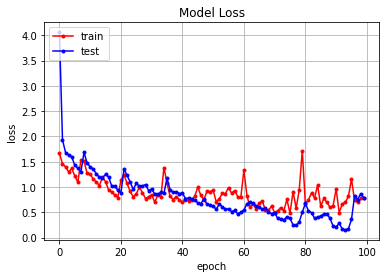

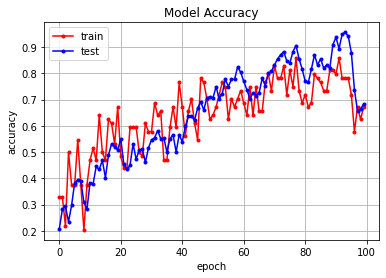

In [8]:
y_vloss = history.history['val_dense_13_loss']
y_loss = history.history['dense_13_loss']
# y_acc = history.history['accuracy']
y_acc = history.history['dense_13_accuracy']
y_vacc = history.history['val_dense_13_accuracy']

#0.6719 scree
  



fig, (ax1) = plt.subplots(1)
ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
ax1.grid()
plt.title('Model Loss')
plt.setp(ax1, xlabel='epoch', ylabel='loss')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./loss per epochs for GoogleNet-graph.jpg")
plt.show()

fig, (ax2) = plt.subplots(1)
ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
ax2.grid()
plt.title('Model Accuracy')
plt.setp(ax2, xlabel='epoch', ylabel='accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./accuracy per epochs for GoogleNet-graph.jpg")
plt.show()
